# Inflow profiles from the rotor plane

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import postproamrwindsample_xarray as ppsamplexr
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def loadpickle(picklefile):
    pfile          = open(picklefile, 'rb')
    ds             = pickle.load(pfile)
    pfile.close()
    return ds

In [3]:
x0     = 2000.0
zhh    = 90
rotorD = 127.0

writeoutputs = True
datadir= 'data_noturb/'

In [4]:
# Load the lidar data
lidardir='../../../precursor/NeutralABL1/postprocessing/'

In [5]:
RPdb = loadpickle('means_noturb/rotor_avg.pkl')

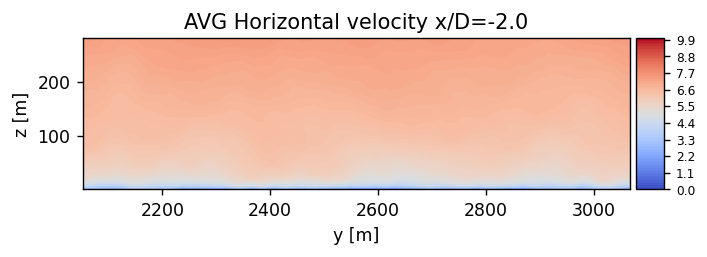

In [18]:
plotplanes = [4] #[4, 5, 6, 7,8]
for iplane in plotplanes:
    fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=125)
    clevels=np.linspace(0, 10,101)
    Uh=np.sqrt(RPdb['velocityx_avg'][iplane,:,:]**2+RPdb['velocityy_avg'][iplane,:,:]**2)
    c=plt.contourf(RPdb['y'][iplane,:,:], RPdb['z'][iplane,:,:], Uh, levels=clevels, cmap='coolwarm')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=7)

    #plt.colorbar()
    ax.axis('scaled')
    ax.set_xlabel('y [m]')
    ax.set_ylabel('z [m]')
    ax.set_title('AVG Horizontal velocity x/D=%0.1f'%((np.mean(RPdb['x'][iplane,:,:])-x0)/rotorD))

In [7]:
# Extract the profiles
allprofiles = {}
plotplanes = [4, 5]
for iplane in plotplanes:
    xplane = (np.mean(RPdb['x'][iplane,:,:])-x0)/rotorD
    zvec   = RPdb['z'][iplane,:,0]
    
    # Horizontal wind speed
    Uh=np.sqrt(RPdb['velocityx_avg'][iplane,:,:]**2+RPdb['velocityy_avg'][iplane,:,:]**2)
    Uh_profile = np.mean(Uh, axis=1)
    
    # Wind direction
    U, V = RPdb['velocityx_avg'][iplane,:,:], RPdb['velocityy_avg'][iplane,:,:]
    winddir = 270-np.arctan2(V, U)*180/np.pi
    WD_profile = np.mean(winddir, axis=1)
    
    # TKE 
    TKE = 0.5*(RPdb['uu_avg'][iplane,:,:] + RPdb['vv_avg'][iplane,:,:] + RPdb['ww_avg'][iplane,:,:])
    TKE_profile = np.mean(TKE, axis=1)
    
    # TI_horiz
    TI = np.sqrt(RPdb['uu_avg'][iplane,:,:] + RPdb['vv_avg'][iplane,:,:])/Uh
    TI_profile = np.mean(TI, axis=1)
    
    T_profile = np.zeros(TI_profile.shape)
    
    profiledict = {}
    profiledict['z'] = zvec
    profiledict['WS'] = Uh_profile
    profiledict['WD'] = WD_profile
    profiledict['TKE'] = TKE_profile
    profiledict['TI_horiz'] = TI_profile
    allprofiles[xplane] = profiledict
    
    if writeoutputs:
        savedat = np.vstack((zvec, Uh_profile, WD_profile, T_profile, TKE_profile, TI_profile))
        fname   = f'AMRWIND_InflowProfiles_noturbine_x_%0.1fD.dat'%xplane
        np.savetxt(datadir+'/'+fname, savedat.transpose(), header="z Uhoriz WDir T TKE TI_horiz")

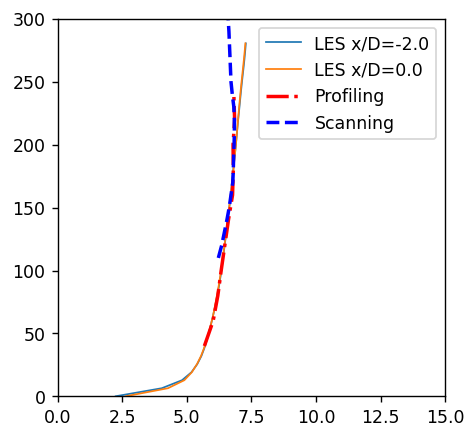

In [8]:
# Plot wind speed
WS_profiling = np.loadtxt(lidardir+'/Profiles_WindSpeed_a1_selectedcase_profiling.txt',delimiter=',')
WS_scanning  = np.loadtxt(lidardir+'/Profiles_WindSpeed_a1_selectedcase_scanning.txt',delimiter=',')   

fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=125)
for x, prof in allprofiles.items():
    ax.plot(prof['WS'], prof['z'], lw=1, label='LES x/D=%0.1f'%x)
    
ax.plot(WS_profiling[:,0], WS_profiling[:,1], 'r-.', label='Profiling', lw=2)
ax.plot(WS_scanning[:,0],  WS_scanning[:,1],  'b--', label='Scanning', lw=2)
ax.set_ylim([0,300])
ax.set_xlim([0, 15])
ax.legend()

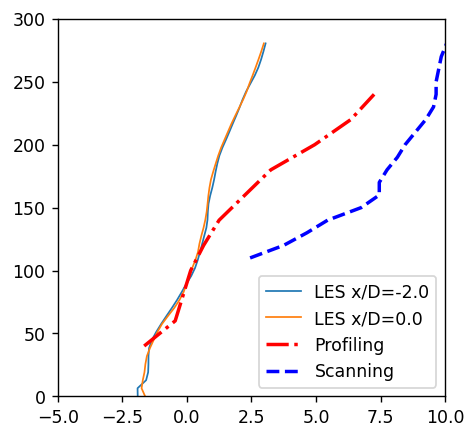

In [9]:
WD_profiling = np.loadtxt(lidardir+'/Profiles_WindDirection_a1_selectedcase_profiling.txt',delimiter=',')
WD_scanning  = np.loadtxt(lidardir+'/Profiles_WindDirection_a1_selectedcase_scanning.txt',delimiter=',')
WD_zhh = np.interp(zhh, WD_profiling[:,1], WD_profiling[:,0])

fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=125)
for x, prof in allprofiles.items():
    zvec = prof['z']
    WD = prof['WD']
    thetahh = np.interp(zhh, zvec, WD)
    ax.plot(WD-thetahh, zvec, lw=1, label='LES x/D=%0.1f'%x)
    
ax.plot(WD_profiling[:,0]-WD_zhh, WD_profiling[:,1], 'r-.', label='Profiling', lw=2)
ax.plot(WD_scanning[:,0]-WD_zhh,  WD_scanning[:,1],  'b--', label='Scanning', lw=2)
ax.set_ylim([0,300])
ax.set_xlim([-5, 10])
ax.legend()

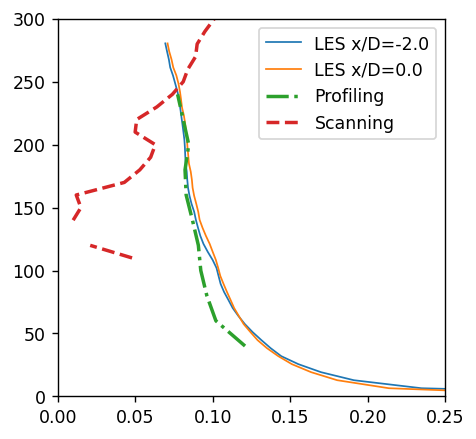

In [10]:
# Plot TI

# Load and plot the lidar data
TI_profiling = np.loadtxt(lidardir+'/Profiles_TurbInt_a1_selectedcase_profiling.txt',delimiter=',')
TI_scanning  = np.loadtxt(lidardir+'/Profiles_TurbInt_a1_selectedcase_scanning.txt',delimiter=',')

fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=125)
for x, prof in allprofiles.items():
    ax.plot(prof['TI_horiz'], prof['z'], lw=1, label='LES x/D=%0.1f'%x)
    
ax.plot(TI_profiling[:,0], TI_profiling[:,1], '-.', label='Profiling', lw=2)
ax.plot(TI_scanning[:,0],  TI_scanning[:,1],  '--', label='Scanning', lw=2)
ax.set_ylim([0, 300])
ax.set_xlim([0, 0.25])
ax.legend()

# Test the hh profile
hhds = loadpickle('means_noturb/turbhh_avg.pkl')
# Plot the turbine hub-height slice
fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=125)
clevels=np.linspace(0, 10,101)
iplane= 0

Uh=np.sqrt(hhds['velocityx_avg'][iplane,:,:]**2+hhds['velocityy_avg'][iplane,:,:]**2)
c=plt.contourf(hhds['x'][iplane,:,:], hhds['y'][iplane,:,:], Uh, levels=clevels, cmap='coolwarm')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(c, ax=ax, cax=cax)
cbar.ax.tick_params(labelsize=7)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('AVG Horizontal velocity')
ax.axis('scaled')

```python
dbfile = open('turbhh_avg_good.pkl', 'wb')
pickle.dump({'X':hhds['x'][iplane,:,:], 
             'Y':hhds['y'][iplane,:,:], 
             'U':hhds['velocityx_avg'][iplane,:,:], 
             'V':hhds['velocityy_avg'][iplane,:,:], 
             'W':hhds['velocityz_avg'][iplane,:,:], }, dbfile, protocol=2)
dbfile.close()
```

# Test the hh profile
hhds = loadpickle('../../AMR.5kmX5km_turbine1/post_processing/pklfiles/AMRWIND_HH_avgVEL.pkl')
# Plot the turbine hub-height slice
fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=125)
clevels=np.linspace(0, 10,101)
iplane= 0

Uh = np.sqrt(hhds['U']**2 + hhds['V']**2)

#Uh=np.sqrt(hhds['U'][iplane,:,:]**2+hhds['velocityy_avg'][iplane,:,:]**2)
c=plt.contourf(hhds['X'], hhds['Y'], Uh, levels=clevels, cmap='coolwarm')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(c, ax=ax, cax=cax)
cbar.ax.tick_params(labelsize=7)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('AVG Horizontal velocity')
ax.axis('scaled')